In [890]:
# Optional: Install dependencies (uncomment if needed)
# !pip install scikit-fuzzy ipywidgets

In [891]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # for centroid if needed

try:
    import skfuzzy as fuzz
    SKFUZZY_AVAILABLE = True
    print("scikit-fuzzy available.")
except ImportError:
    SKFUZZY_AVAILABLE = False
    print("scikit-fuzzy not available; using numpy fallbacks.")

try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
    print("ipywidgets available for interactive sliders.")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available; using manual input.")

scikit-fuzzy available.
ipywidgets available for interactive sliders.


## Define Universes

We define three universes of discourse:
- Food quality: 0 to 10
- Service quality: 0 to 10
- Tip percentage: 0 to 30

Using np.linspace for 100 points each for smooth plotting.

In [892]:
# Define universes
food_universe = np.linspace(0, 10, 100)
service_universe = np.linspace(0, 10, 100)
tip_universe = np.linspace(0, 30, 100)

## Membership Functions

- **Food quality**: Trapezoidal shapes for "rancid", "fine", "delicious"
  - Rancid: [0, 0, 1, 3]
  - Fine: [1, 3, 7, 9]
  - Delicious: [7, 9, 10, 10]

- **Service quality**: Gaussian shapes for "poor", "good", "excellent"
  - Poor: mean=2.0, sigma=1.0 (clipped <0.2 to 0)
  - Good: mean=5.0, sigma=1.2 (clipped <0.02 to 0)
  - Excellent: mean=7.0, sigma=1.2 (clipped for x<5 to 0)

- **Tip percentage**: Triangular shapes for "low", "average", "high"
  - Low: [0, 6.8, 15]
  - Average: [6.8, 15, 23.2]
  - High: [15, 23.2, 30]

Note: Different membership function types are used - trapezoidal for food (for plateaus), Gaussian for service (for smooth transitions), triangular for tip.

In [893]:
# Membership functions
# Note: Different MF types used - trapezoidal for food (plateaus), Gaussian for service (smooth transitions), triangular for tip
def trapezoidal(x, a, b, c, d):
    return np.piecewise(x, [x < a, (a <= x) & (x < b), (b <= x) & (x < c), (c <= x) & (x < d), x >= d],
                         [0, lambda x: (x - a) / (b - a), 1, lambda x: (d - x) / (d - c), 0])

def triangular(x, a, b, c):
    return np.piecewise(x, [x < a, (a <= x) & (x < b), (b <= x) & (x < c), x >= c],
                         [0, lambda x: (x - a) / (b - a), lambda x: (c - x) / (c - b), 0])

def gaussian(x, mean, sigma):
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# Food memberships
food_rancid = trapezoidal(food_universe, 0, 0, 2, 4)
food_fine = trapezoidal(food_universe, 2, 4, 6, 8)
food_delicious = trapezoidal(food_universe, 6, 8, 10, 10)

# Service memberships
# Poor: peaks at 0; Good: peaks at 5; Excellent: peaks at 10
service_poor = gaussian(service_universe, 0.0, 1.5)
service_good = gaussian(service_universe, 5.0, 1.539)
service_excellent = gaussian(service_universe, 10.0, 1.437)

# Tip memberships
tip_low = triangular(tip_universe, 0, 5, 15)
tip_average = triangular(tip_universe, 6, 15, 25)
tip_high = triangular(tip_universe, 15, 25, 30)

# Dictionary for easy access
food_mfs = {'rancid': food_rancid, 'fine': food_fine, 'delicious': food_delicious}
service_mfs = {'poor': service_poor, 'good': service_good, 'excellent': service_excellent}
tip_mfs = {'low': tip_low, 'average': tip_average, 'high': tip_high}

## Fuzzification Function

The fuzzification function takes a crisp value and returns the membership degrees for each linguistic term.

In [894]:
def fuzzify(value, universe, mfs):
    # Use interpolation for smooth fuzzification
    return {name: np.interp(value, universe, mf) for name, mf in mfs.items()}

## Demonstrate Fuzzification

For food = 7 and service = 8, compute membership values.

In [895]:
food_input = 7
service_input = 8

food_memberships = fuzzify(food_input, food_universe, food_mfs)
service_memberships = fuzzify(service_input, service_universe, service_mfs)

print("Food quality memberships at 7:")
for term, deg in food_memberships.items():
    print(f"  {term}: {deg:.3f}")

print("\nService quality memberships at 8:")
for term, deg in service_memberships.items():
    print(f"  {term}: {deg:.3f}")

Food quality memberships at 7:
  rancid: 0.000
  fine: 0.500
  delicious: 0.500

Service quality memberships at 8:
  poor: 0.000
  good: 0.150
  excellent: 0.380


## Fuzzy Rules

The three rules:
1. If service is poor OR food is rancid then tip is low
2. If service is good then tip is average
3. If service is excellent OR food is delicious then tip is high

Using max for OR, min for AND (though no AND here).

In [896]:
# Rules as functions
def rule1(food_m, service_m):
    return max(service_m['poor'], food_m['rancid'])

def rule2(food_m, service_m):
    return service_m['good']

def rule3(food_m, service_m):
    return max(service_m['excellent'], food_m['delicious'])

rules = [rule1, rule2, rule3]
rule_outputs = ['low', 'average', 'high']

## Compute Firing Strengths

For the example inputs.

In [897]:
firing_strengths = [rule(food_memberships, service_memberships) for rule in rules]

print("Firing strengths:")
for i, fs in enumerate(firing_strengths, 1):
    print(f"  Rule {i}: {fs:.6f}")

Firing strengths:
  Rule 1: 0.000001
  Rule 2: 0.149724
  Rule 3: 0.500000


## Implication and Aggregation

For each rule, clip the output membership at the firing strength, then aggregate using maximum.

In [898]:
# Clipped outputs
clipped_low = np.minimum(tip_mfs['low'], firing_strengths[0])
clipped_average = np.minimum(tip_mfs['average'], firing_strengths[1])
clipped_high = np.minimum(tip_mfs['high'], firing_strengths[2])

# Aggregate
aggregated = np.maximum(np.maximum(clipped_low, clipped_average), clipped_high)

## Centroid Defuzzification

Compute the centroid: integral(x * mu(x)) / integral(mu(x))

In [899]:
def centroid_defuzzify(universe, aggregated):
    numerator = trapezoid(universe * aggregated, universe)
    denominator = trapezoid(aggregated, universe)
    return numerator / denominator if denominator != 0 else 0

crisp_tip = centroid_defuzzify(tip_universe, aggregated)
print(f"Crisp tip percentage: {crisp_tip:.2f}%")

Crisp tip percentage: 20.75%


## Plots

Plot all membership functions, fuzzified inputs, clipped outputs, aggregated, and centroid.

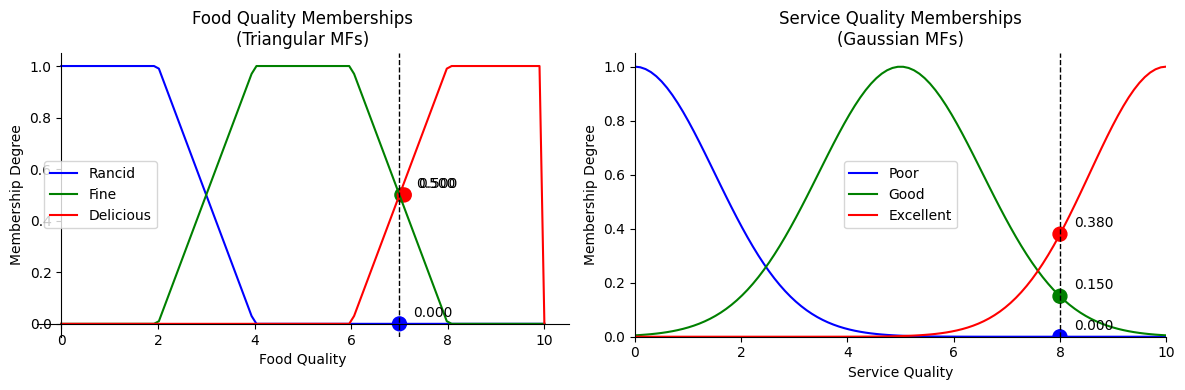

In [900]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Food membership functions with dots
axes[0].plot(food_universe, food_rancid, 'b', label='Rancid')
axes[0].plot(food_universe, food_fine, 'g', label='Fine')
axes[0].plot(food_universe, food_delicious, 'r', label='Delicious')
axes[0].scatter([food_input, food_input + 0.05, food_input + 0.1], [food_memberships['rancid'], food_memberships['fine'], food_memberships['delicious']], c=['b','g','r'], s=100, marker='o')
axes[0].axvline(food_input, color='k', linestyle='--', linewidth=1)
axes[0].annotate(f"{food_memberships['rancid']:.3f}", (food_input, food_memberships['rancid']), textcoords="offset points", xytext=(10,5), ha='left')
axes[0].annotate(f"{food_memberships['fine']:.3f}", (food_input + 0.05, food_memberships['fine']), textcoords="offset points", xytext=(10,5), ha='left')
axes[0].annotate(f"{food_memberships['delicious']:.3f}", (food_input + 0.1, food_memberships['delicious']), textcoords="offset points", xytext=(10,5), ha='left')
axes[0].set_title('Food Quality Memberships\n(Triangular MFs)')
axes[0].set_xlabel('Food Quality')
axes[0].set_ylabel('Membership Degree')
axes[0].legend()
# Make axes cross at 0,0
axes[0].spines['left'].set_position('zero')
axes[0].spines['bottom'].set_position('zero')
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')

# 2. Service membership functions with dots
axes[1].plot(service_universe, service_poor, 'b', label='Poor')
axes[1].plot(service_universe, service_good, 'g', label='Good')
axes[1].plot(service_universe, service_excellent, 'r', label='Excellent')
axes[1].scatter([service_input, service_input, service_input], [service_memberships['poor'], service_memberships['good'], service_memberships['excellent']], c=['b','g','r'], s=100, marker='o')
axes[1].axvline(service_input, color='k', linestyle='--', linewidth=1)
for name, val in service_memberships.items():
    axes[1].annotate(f'{val:.3f}', (service_input, val), textcoords="offset points", xytext=(10,5), ha='left')
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 1.05)
axes[1].set_title('Service Quality Memberships\n(Gaussian MFs)')
axes[1].set_xlabel('Service Quality')
axes[1].set_ylabel('Membership Degree')
axes[1].legend()
# Make axes cross at 0,0
axes[1].spines['left'].set_position('zero')
axes[1].spines['bottom'].set_position('zero')
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].xaxis.set_ticks_position('bottom')
axes[1].yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig('fuzzy_plots_1.png', dpi=150, bbox_inches='tight')
plt.show()

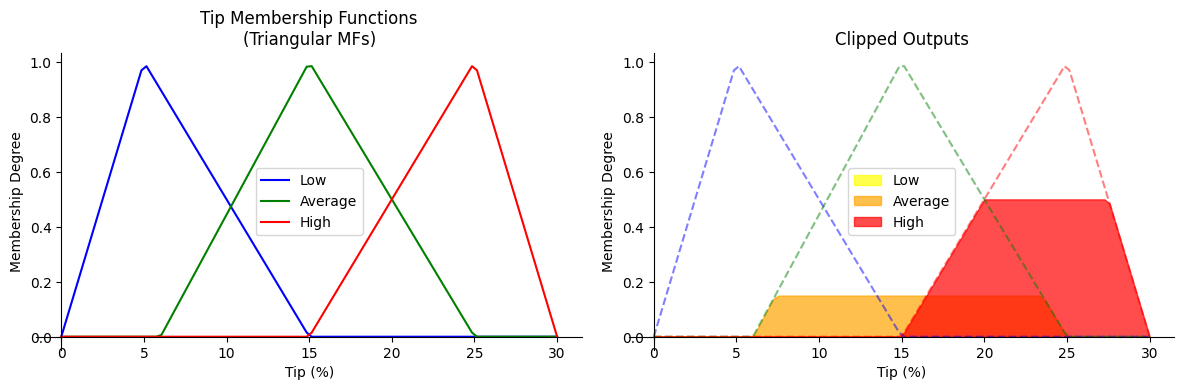

In [901]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 3. Tip membership triangles
axes[0].plot(tip_universe, tip_low, 'b', label='Low')
axes[0].plot(tip_universe, tip_average, 'g', label='Average')
axes[0].plot(tip_universe, tip_high, 'r', label='High')
axes[0].set_title('Tip Membership Functions\n(Triangular MFs)')
axes[0].set_xlabel('Tip (%)')
axes[0].set_ylabel('Membership Degree')
axes[0].legend()
# Make axes cross at 0,0
axes[0].spines['left'].set_position('zero')
axes[0].spines['bottom'].set_position('zero')
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].yaxis.set_ticks_position('left')

# 4. Clipped and shaded tip regions
axes[1].plot(tip_universe, tip_low, 'b--', alpha=0.5)
axes[1].fill_between(tip_universe, 0, clipped_low, color='yellow', alpha=0.7, label='Low')
axes[1].plot(tip_universe, tip_average, 'g--', alpha=0.5)
axes[1].fill_between(tip_universe, 0, clipped_average, color='orange', alpha=0.7, label='Average')
axes[1].plot(tip_universe, tip_high, 'r--', alpha=0.5)
axes[1].fill_between(tip_universe, 0, clipped_high, color='red', alpha=0.7, label='High')
axes[1].set_title('Clipped Outputs')
axes[1].set_xlabel('Tip (%)')
axes[1].set_ylabel('Membership Degree')
axes[1].legend()
# Make axes cross at 0,0
axes[1].spines['left'].set_position('zero')
axes[1].spines['bottom'].set_position('zero')
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')
axes[1].xaxis.set_ticks_position('bottom')
axes[1].yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig('fuzzy_plots_2.png', dpi=150, bbox_inches='tight')
plt.show()

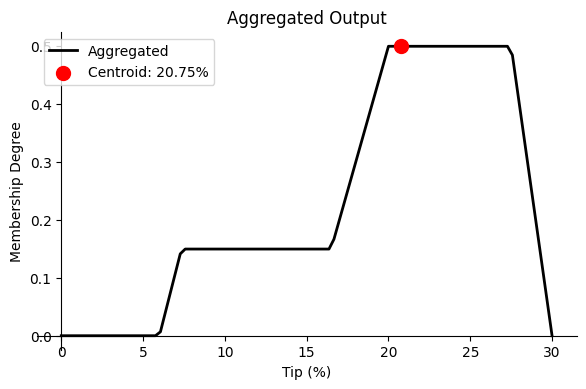

In [902]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 5. Aggregated output with centroid
ax.plot(tip_universe, aggregated, 'k-', linewidth=2, label='Aggregated')
idx = np.argmin(np.abs(tip_universe - crisp_tip))
ax.scatter(crisp_tip, aggregated[idx], color='red', s=100, zorder=5, label=f'Centroid: {crisp_tip:.2f}%')
ax.set_title('Aggregated Output')
ax.set_xlabel('Tip (%)')
ax.set_ylabel('Membership Degree')
ax.legend()
# Make axes cross at 0,0
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig('fuzzy_plots_3.png', dpi=150, bbox_inches='tight')
plt.show()

## Full Input-to-Output Surface

Generate the surface by evaluating the FIS over the entire food × service grid.

In [903]:
# Grid
food_grid, service_grid = np.meshgrid(np.linspace(0,10,50), np.linspace(0,10,50))
tip_surface = np.zeros_like(food_grid)

for i in range(food_grid.shape[0]):
    for j in range(food_grid.shape[1]):
        f_m = fuzzify(food_grid[i,j], food_universe, food_mfs)
        s_m = fuzzify(service_grid[i,j], service_universe, service_mfs)
        fs = [rule(f_m, s_m) for rule in rules]
        clipped = [np.minimum(tip_mfs[out], fs[k]) for k, out in enumerate(rule_outputs)]
        agg = np.maximum.reduce(clipped)
        tip_surface[i,j] = centroid_defuzzify(tip_universe, agg)

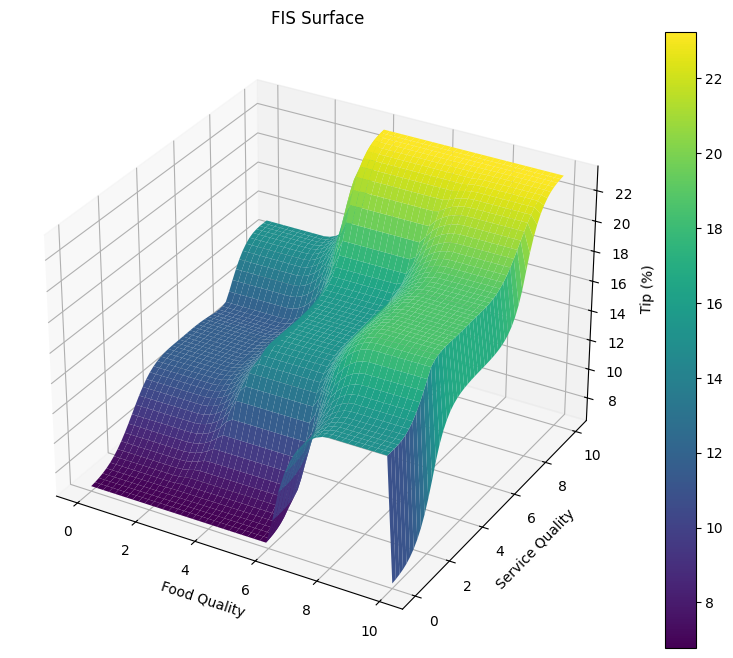

In [904]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(food_grid, service_grid, tip_surface, cmap='viridis')
ax.set_xlabel('Food Quality')
ax.set_ylabel('Service Quality')
ax.set_zlabel('Tip (%)')
ax.set_title('FIS Surface')
fig.colorbar(surf)
plt.show()

## Lookup Table

The surface can be stored in a numpy array for low-compute use.

In [905]:
lookup_table = tip_surface
print("Lookup table shape:", lookup_table.shape)
print("Example: food=5, service=5 -> tip ~", lookup_table[25,25])  # approx indices

Lookup table shape: (50, 50)
Example: food=5, service=5 -> tip ~ 15.32937064906039


## Add Fourth Rule

Add: if food is fine then tip is high

In [906]:
def rule4(food_m, service_m):
    return food_m['fine']

rules.append(rule4)
rule_outputs.append('high')

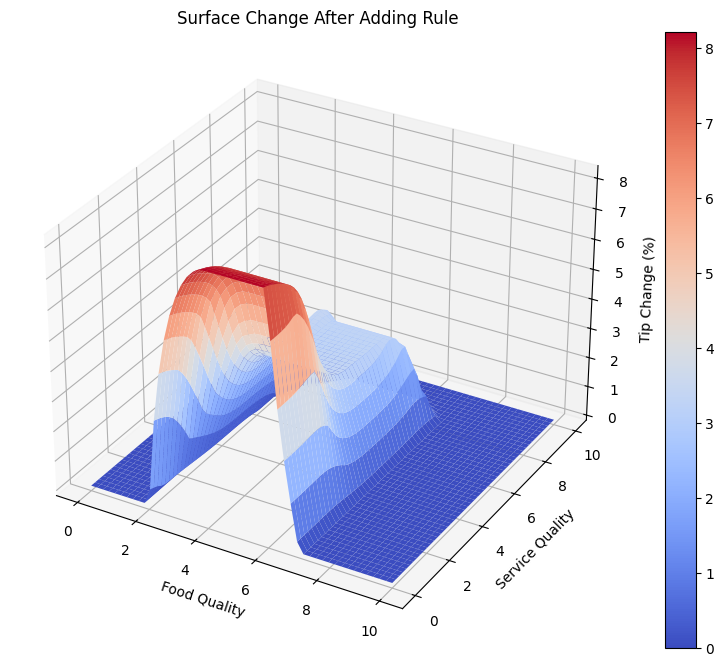

In [907]:
# Regenerate surface
tip_surface_new = np.zeros_like(food_grid)

for i in range(food_grid.shape[0]):
    for j in range(food_grid.shape[1]):
        f_m = fuzzify(food_grid[i,j], food_universe, food_mfs)
        s_m = fuzzify(service_grid[i,j], service_universe, service_mfs)
        fs = [rule(f_m, s_m) for rule in rules]
        clipped = [np.minimum(tip_mfs[out], fs[k]) for k, out in enumerate(rule_outputs)]
        agg = np.maximum.reduce(clipped)
        tip_surface_new[i,j] = centroid_defuzzify(tip_universe, agg)

# Plot difference
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(food_grid, service_grid, tip_surface_new - tip_surface, cmap='coolwarm')
ax.set_xlabel('Food Quality')
ax.set_ylabel('Service Quality')
ax.set_zlabel('Tip Change (%)')
ax.set_title('Surface Change After Adding Rule')
fig.colorbar(surf)
plt.show()

## Evaluate Function

In [908]:
def evaluate(food, service):
    f_m = fuzzify(food, food_universe, food_mfs)
    s_m = fuzzify(service, service_universe, service_mfs)
    fs = [rule(f_m, s_m) for rule in rules]
    clipped = [np.minimum(tip_mfs[out], fs[k]) for k, out in enumerate(rule_outputs)]
    agg = np.maximum.reduce(clipped)
    return centroid_defuzzify(tip_universe, agg)

print("Evaluate(7,8):", evaluate(7,8))

Evaluate(7,8): 20.74927995629225


## Interactive Exploration

In [909]:
if WIDGETS_AVAILABLE:
    food_slider = widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description='Food:')
    service_slider = widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description='Service:')
    
    def update_plot(food, service):
        tip = evaluate(food, service)
        print(f"Food: {food}, Service: {service} -> Tip: {tip:.2f}%")
    
    widgets.interactive(update_plot, food=food_slider, service=service_slider)
else:
    # Manual input example
    food_manual = 7.0
    service_manual = 8.0
    tip_manual = evaluate(food_manual, service_manual)
    print(f"Example: Food: {food_manual}, Service: {service_manual} -> Tip: {tip_manual:.2f}%")

## Checks/Asserts

In [910]:
# Check fuzzification
assert abs(fuzzify(0, food_universe, food_mfs)['rancid'] - 1.0) < 0.01
assert abs(fuzzify(9, food_universe, food_mfs)['delicious'] - 1.0) < 0.01
assert abs(fuzzify(5, service_universe, service_mfs)['good'] - gaussian(5,5,1.2)) < 0.01

# Check centroid for uniform
uniform_mu = np.ones_like(tip_universe)
centroid_uniform = centroid_defuzzify(tip_universe, uniform_mu)
assert abs(centroid_uniform - 15) < 1  # midpoint

print("All checks passed.")

All checks passed.


## Conclusion

Membership shapes affect sensitivity: Gaussian for smooth transitions, trapezoidal for plateaus. Operator selection (max for OR) influences rule strength. Rule base design determines behavior complexity. This FIS provides interpretable, non-linear mapping suitable for microcontrollers via lookup tables.

In [913]:
# Interactive Sliders for Graphs
# Use sliders to change food and service inputs and see the graphs update in real-time.

from ipywidgets import interact, FloatSlider
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_interactive(food, service):
    clear_output(wait=True)
    plt.close('all')  # Close all previous figures
    # Compute memberships
    food_memberships = fuzzify(food, food_universe, food_mfs)
    service_memberships = fuzzify(service, service_universe, service_mfs)
    
    # Compute firing strengths
    firing_strengths = [rule(food_memberships, service_memberships) for rule in rules]
    
    # Clipped outputs
    clipped_low = np.minimum(tip_mfs['low'], firing_strengths[0])
    clipped_average = np.minimum(tip_mfs['average'], firing_strengths[1])
    clipped_high = np.minimum(tip_mfs['high'], firing_strengths[2])
    
    # Aggregate
    aggregated = np.maximum(np.maximum(clipped_low, clipped_average), clipped_high)
    crisp_tip = centroid_defuzzify(tip_universe, aggregated)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Food memberships with dots
    axes[0,0].plot(food_universe, food_rancid, 'b', label='Rancid')
    axes[0,0].plot(food_universe, food_fine, 'g', label='Fine')
    axes[0,0].plot(food_universe, food_delicious, 'r', label='Delicious')
    axes[0,0].scatter([food, food + 0.05, food + 0.1], [food_memberships['rancid'], food_memberships['fine'], food_memberships['delicious']], c=['b','g','r'], s=100, marker='o')
    axes[0,0].axvline(food, color='k', linestyle='--', linewidth=1)
    axes[0,0].annotate(f"{food_memberships['rancid']:.3f}", (food, food_memberships['rancid']), textcoords="offset points", xytext=(10,5), ha='left')
    axes[0,0].annotate(f"{food_memberships['fine']:.3f}", (food + 0.05, food_memberships['fine']), textcoords="offset points", xytext=(10,5), ha='left')
    axes[0,0].annotate(f"{food_memberships['delicious']:.3f}", (food + 0.1, food_memberships['delicious']), textcoords="offset points", xytext=(10,5), ha='left')
    axes[0,0].set_title('Food Quality Memberships')
    axes[0,0].set_xlabel('Food Quality')
    axes[0,0].set_ylabel('Membership Degree')
    axes[0,0].legend()
    axes[0,0].set_xlim(0, 10)
    axes[0,0].set_ylim(0, 1.05)
    
    # Service memberships with dots
    axes[0,1].plot(service_universe, service_poor, 'b', label='Poor')
    axes[0,1].plot(service_universe, service_good, 'g', label='Good')
    axes[0,1].plot(service_universe, service_excellent, 'r', label='Excellent')
    axes[0,1].scatter([service, service, service], [service_memberships['poor'], service_memberships['good'], service_memberships['excellent']], c=['b','g','r'], s=100, marker='o')
    axes[0,1].axvline(service, color='k', linestyle='--', linewidth=1)
    for name, val in service_memberships.items():
        axes[0,1].annotate(f'{val:.3f}', (service, val), textcoords="offset points", xytext=(10,5), ha='left')
    axes[0,1].set_xlim(0, 10)
    axes[0,1].set_ylim(0, 1.05)
    axes[0,1].set_title('Service Quality Memberships')
    axes[0,1].set_xlabel('Service Quality')
    axes[0,1].set_ylabel('Membership Degree')
    axes[0,1].legend()
    
    # Clipped outputs
    axes[1,0].plot(tip_universe, tip_low, 'b--', alpha=0.5)
    axes[1,0].fill_between(tip_universe, 0, clipped_low, color='yellow', alpha=0.7, label='Low')
    axes[1,0].plot(tip_universe, tip_average, 'g--', alpha=0.5)
    axes[1,0].fill_between(tip_universe, 0, clipped_average, color='orange', alpha=0.7, label='Average')
    axes[1,0].plot(tip_universe, tip_high, 'r--', alpha=0.5)
    axes[1,0].fill_between(tip_universe, 0, clipped_high, color='red', alpha=0.7, label='High')
    axes[1,0].set_title('Clipped Outputs')
    axes[1,0].set_xlabel('Tip (%)')
    axes[1,0].set_ylabel('Membership Degree')
    axes[1,0].legend()
    axes[1,0].set_xlim(0, 30)
    axes[1,0].set_ylim(0, 1.05)
    
    # Aggregated output with centroid
    axes[1,1].plot(tip_universe, aggregated, 'k-', linewidth=2, label='Aggregated')
    idx = np.argmin(np.abs(tip_universe - crisp_tip))
    axes[1,1].scatter(crisp_tip, aggregated[idx], color='red', s=100, zorder=5, label=f'Centroid: {crisp_tip:.2f}%')
    axes[1,1].set_title('Aggregated Output')
    axes[1,1].set_xlabel('Tip (%)')
    axes[1,1].set_ylabel('Membership Degree')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 30)
    axes[1,1].set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(plot_interactive, food=FloatSlider(min=0, max=10, step=0.1, value=7, description='Food:'), service=FloatSlider(min=0, max=10, step=0.1, value=8, description='Service:'))

interactive(children=(FloatSlider(value=7.0, description='Food:', max=10.0), FloatSlider(value=8.0, descriptio…

<function __main__.plot_interactive(food, service)>